In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-equality-curriculum-recommendations/sample_submission.csv
/kaggle/input/learning-equality-curriculum-recommendations/topics.csv
/kaggle/input/learning-equality-curriculum-recommendations/correlations.csv
/kaggle/input/learning-equality-curriculum-recommendations/content.csv


# Goal of the Competition
The goal of this competition is to streamline the process of matching educational content to specific topics in a curriculum. You will develop an accurate and efficient model trained on a library of K-12 educational materials that have been organized into a variety of topic taxonomies. These materials are in diverse languages, and cover a wide range of topics, particularly in STEM (Science, Technology, Engineering, and Mathematics).

Your work will enable students and educators to more readily access relevant educational content to support and supplement learning.

# Context
Every country in the world has its own educational structure and learning objectives. Most materials are categorized against a single national system or are not organized in a way that facilitates discovery. The process of curriculum alignment, the organization of educational resources to fit standards, is challenging as it varies between country contexts.

Current efforts to align digital materials to national curricula are manual and require time, resources, and curricular expertise, and the process needs to be made more efficient in order to be scalable and sustainable. As new materials become available, they require additional efforts to be realigned, resulting in a never-ending process. There are no current algorithms or other AI interventions that address the resource constraints associated with improving the process of curriculum alignment.

Competition host Learning Equality is committed to enabling every person in the world to realize their right to a quality education, by supporting the creation, adaptation, and distribution of open educational resources, and creating supportive tools for innovative pedagogy. Their core product is Kolibri, an adaptable set of open solutions and tools specially designed to support offline-first teaching and learning for the 37% of the world without Internet access. Their close partner UNHCR has consistently highlighted the strong need and innovation required to create automated alignment tools to ensure refugee learners and teachers are provided with relevant digital learning resources. They have been jointly exploring this challenge in depth for the past few years, engaging with curriculum designers, teachers, and machine learning experts. In addition, Learning Equality is partnering with The Learning Agency Lab, an​ independent nonprofit focused on developing science of learning-based tools and programs for social good, along with UNHCR to engage you in this important process.

You have the opportunity to use your skills in machine learning to support educators and students around the world in accessing aligned learning materials that are relevant for their particular context. Better curriculum alignment processes are especially impactful during the onset of new emergencies or crises, where rapid support is needed, such as for refugee learners, and during school closures as took place during COVID-19.

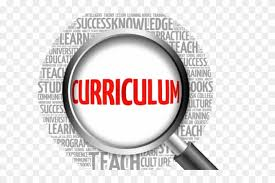

In [2]:
import os
import json
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS
import json
from tqdm.auto import tqdm
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
import transformers
import torch
from tqdm.notebook import tqdm
from pathlib import Path
from fuzzywuzzy import fuzz, process
import math
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

In [3]:
content=pd.read_csv('/kaggle/input/learning-equality-curriculum-recommendations/content.csv')
topics=pd.read_csv('/kaggle/input/learning-equality-curriculum-recommendations/topics.csv')
correlations=pd.read_csv('/kaggle/input/learning-equality-curriculum-recommendations/correlations.csv')
submission=pd.read_csv('/kaggle/input/learning-equality-curriculum-recommendations/sample_submission.csv')


### Checking each file

# Content

In [4]:
content[content.language=='en']['kind'].value_counts()

video       22444
html5       21324
exercise    11485
document    10636
audio          50
Name: kind, dtype: int64

In [5]:
for col in content.columns:
    print(col)
    print('unique_values',content[col].unique())
    print('Number_of_unique',content[col].nunique())
    print('missing_values',content[col].isnull().sum())
    print('missing_values%',round((content[col].isnull().sum()/content.shape[0])*100,2))
    print('---------------')

id
unique_values ['c_00002381196d' 'c_000087304a9e' 'c_0000ad142ddb' ... 'c_fffed7b0d13a'
 'c_ffff04ba7ac7' 'c_ffffe5254266']
Number_of_unique 154047
missing_values 0
missing_values% 0.0
---------------
title
unique_values ['Sumar números de varios dígitos: 48,029+233,930 '
 'Trovare i fattori di un numero' 'Sumar curvas de demanda' ...
 'Introdução à subtração' 'SA of a Cone' 'The Jats']
Number_of_unique 130937
missing_values 9
missing_values% 0.01
---------------
description
unique_values ['Suma 48,029+233,930 mediante el algoritmo estándar.\n\n'
 'Sal trova i fattori di 120.\n\n' 'Cómo añadir curvas de demanda\n\n' ...
 '5ad47e52f342d704a6253217'
 'Sal somma 5+68 spezzando il 5 in un 2 e un 3.\n\n'
 'Sal fala sobre o que significa subtrair. Os exemplos que ele usa são 4-3 e\n5-2.\n\n']
Number_of_unique 76305
missing_values 64591
missing_values% 41.93
---------------
kind
unique_values ['video' 'document' 'html5' 'exercise' 'audio']
Number_of_unique 5
missing_values 0
missing_values%

* Our content columns (from data description)
* id - A unique identifier for this content item.
* title - Title text for this content item.
* description - Description text. May be empty.
* language - Language code representing the language of this content item.
* kind - Describes what format of content this item represents, as one of:
* document (text is extracted from a PDF or EPUB file)
* video (text is extracted from the subtitle file, if available)
* exercise (text is extracted from questions/answers)
* audio (no text)
* html5 (text is extracted from HTML source)
* text - Extracted text content, if available and if licensing permitted (around half of content items have text content).
* copyright_holder - If text was extracted from the content, indicates the owner of the copyright for that content. Blank for all test set items.
* license - If text was extracted from the content, the license under which that content was made available. Blank for all test set items.

* ID,kind,language has zero null values 
* Title has 130937 unique values and 0.01% missing values
* Description has 41.93% missing values
* Text has 51.94% missing values
* 27 languages
* Copyright_holder has 148 unique values and 53.38% missing data
* License has 51.94% missing data!

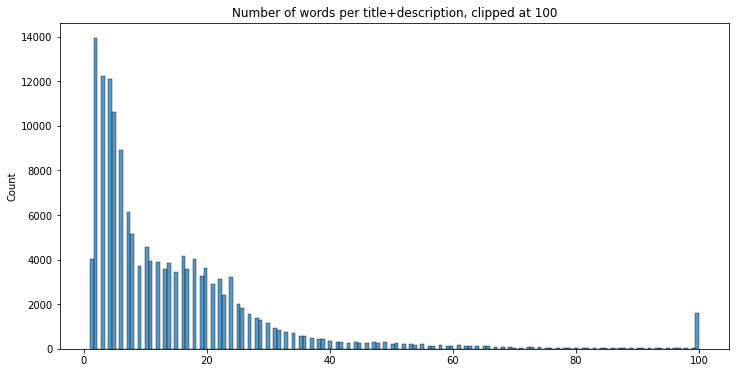

In [6]:
texts = content['title'].fillna('') + ' ' + content['description'].fillna('')
title_desc_len = np.clip(texts.apply(lambda x: len(x.strip().split(' '))), 0, 100)
plt.figure(figsize=(12,6))
sns.histplot(title_desc_len)
plt.title('Number of words per title+description, clipped at 100')
plt.show()

Descriptions missing but transformers can handle that
<100 words as well, looks like you can input Topic x Content in a transformer easily.

## kind&text

In [7]:
content.head(2)

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN


<AxesSubplot:xlabel='kind', ylabel='count'>

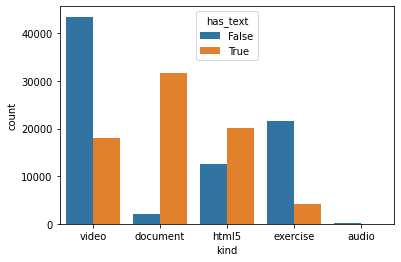

In [8]:
content['has_text']=~content['text'].isna()
sns.countplot(x='kind',hue='has_text',data=content)

# LET'S CHECK THE # OF LANGUAGES IN CONTENT

<AxesSubplot:xlabel='kind', ylabel='count'>

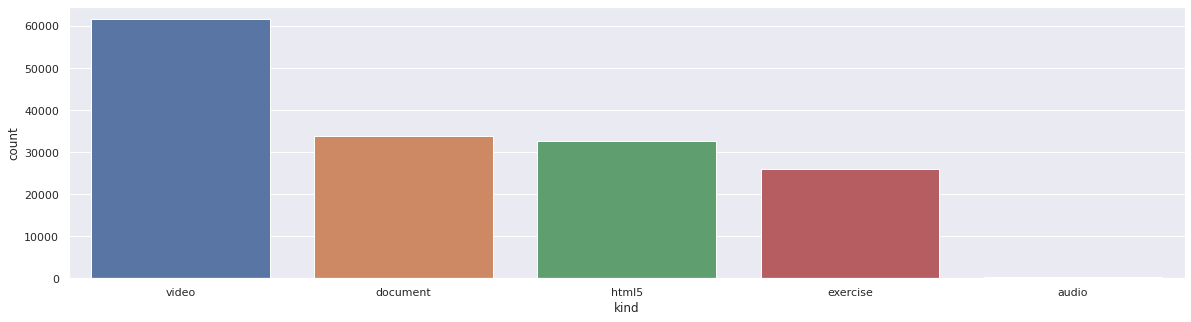

In [9]:
# Our kinds numbers
sns.set(rc={'figure.figsize':(20,5)})
sns.countplot(x='kind', data=content)

Video is highest kind in dataset followed by document

# Most common words

In [10]:
import re
def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

In [11]:
# tokenize data
content["tokenized_description"] = content.description.apply(lambda x: tokenize(x))
# calculate token count for any sent
content["sent_token_length"] = content["tokenized_description"].apply(lambda x: len(x.split()))

In [12]:
fig = px.histogram(content, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

# Topics

In [13]:
topics.head(2)

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False


In [14]:
for col in topics.columns:
    print(col)
    print('unique_values',topics[col].unique())
    print('Number_of_unique',topics[col].nunique())
    print('missing_values',topics[col].isnull().sum())
    print('missing_values%',round((topics[col].isnull().sum()/topics.shape[0])*100,2))
    print('---------------')

id
unique_values ['t_00004da3a1b2' 't_000095e03056' 't_00068291e9a4' ... 't_fffe14f1be1e'
 't_fffe811a6da9' 't_fffe88835149']
Number_of_unique 76972
missing_values 0
missing_values% 0.0
---------------
title
unique_values ['Откриването на резисторите' 'Unit 3.3 Enlargements and Similarities'
 'Entradas e saídas de uma função' ... 'Scalar Projections'
 'NA_U06 - El periódico'
 'تحديد العلاقة بين الإحداثيّات القطبية والإحداثيّات الديكارتيّة']
Number_of_unique 45082
missing_values 2
missing_values% 0.0
---------------
description
unique_values ['Изследване на материали, които предизвикват намаление в отклонението, когато се свържат последователно с нашия измервателен уред. '
 nan 'Entenda um pouco mais sobre funções.' ...
 'In certain situations, comparison by division makes better sense than comparison by taking the difference. The comparison by division is called the ratio of the two numbers. In this chapter we will introduce the concept of ratios and proportions.'
 'Aprenda a fatorar u

* Id,title,channel,category,level,language and has content columns have zero null values
* Description got 54.59% missing data
* Parent has few missing data <0.22%

# Our topics columns (from data description)
* id - A unique identifier for this topic.
* title - Title text for this topic.
* description - Description text (may be empty)
* channel - The channel (that is, topic tree) this topic is part of.
* category - Describes the origin of the topic.
    * source - Structure was given by original content creator (e.g. the topic tree as imported from Khan Academy). There are no topics in the test set with this category.
    * aligned - Structure is from a national curriculum or other target taxonomy, with content aligned from multiple sources.
    * supplemental - This is a channel that has to some extent been aligned, with without the same level of granularity or fidelity as an aligned channel.
* language - Language code for the topic. May not always match apparent language of its title or description, but will always match the language of any associated content items.
* parent - The id of the topic that contains this topic, if any. This field if empty if the topic is the root node for its channel.
* level - The depth of this topic within its topic tree. Level 0 means it is a root node (and hence its title is the title of the channel).
* has_content - Whether there are content items correlated with this topic. Most content is correlated with leaf topics, but some non-leaf topics also have content correlations.

> combining both title and description as latter has more null values

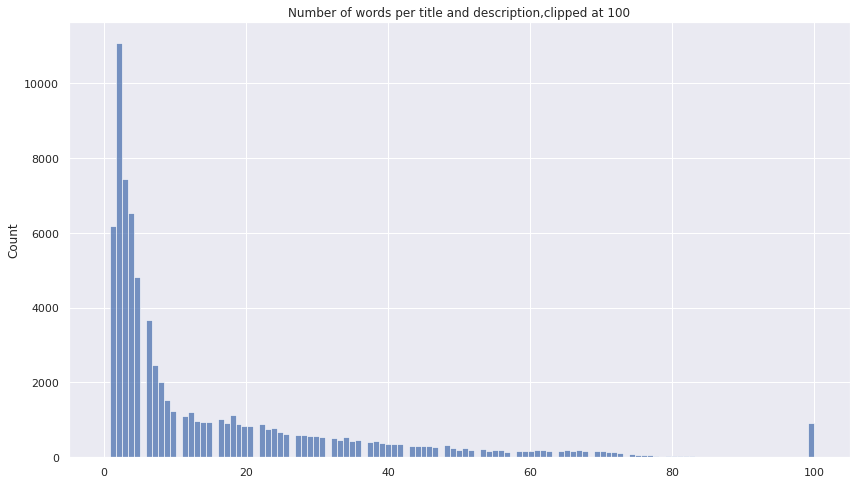

In [15]:
texts=topics['title'].fillna('')+' '+topics['description'].fillna('')
title_desc_len=np.clip(texts.apply(lambda x:len(x.strip().split())),0,100)#To keep the length of words in the range of 0 to 100
plt.figure(figsize=(14,8))
sns.histplot(title_desc_len)
plt.title('Number of words per title and description,clipped at 100')
plt.show()

It seems like we have words in the range of 0-10

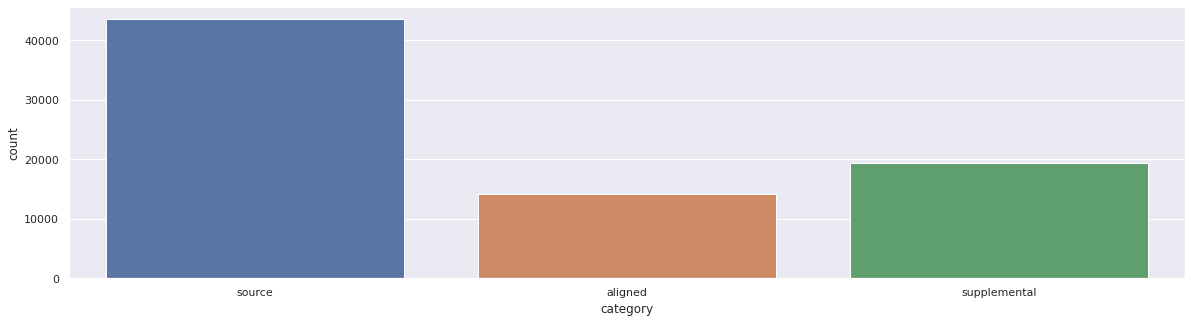

In [16]:
sns.countplot(x='category',data=topics)
plt.show()

In [17]:
print(f'Proportion of "useful" topics : {topics["has_content"].mean() :.3f}')

Proportion of "useful" topics : 0.799


20% of topics do not have associated content. I'm assuming this column is not available during inference.

# Language

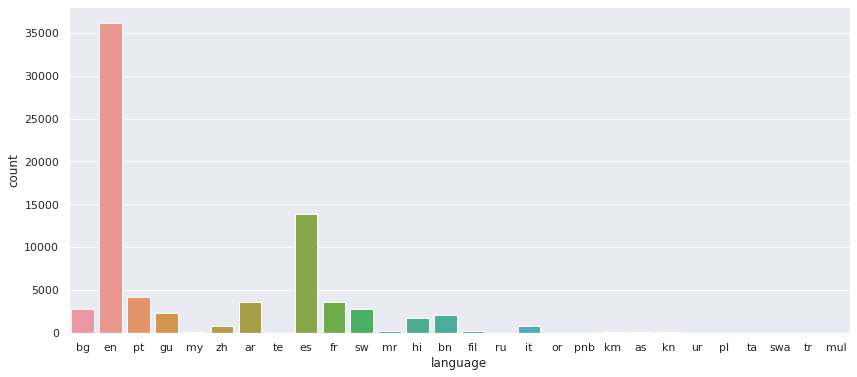

In [18]:
plt.figure(figsize=(14,6))
sns.countplot(x='language',data=topics)
plt.show()

english is top most language followed by spanish

In [19]:
topics_en = (topics[topics['language'] == 'en']).dropna()
def word_cloud(text, title): 
    fig, axes = plt.subplots(figsize=(12,8))
    
    fig.subplots_adjust(top=0.8)
    
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(background_color="white",
                    max_words=3000, 
                    stopwords=stopwords)    

    wordcloud.generate(' '.join(map(str, (word for word in text))))
    
    plt.imshow(wordcloud, interpolation='hamming')
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title(title, fontsize=20);

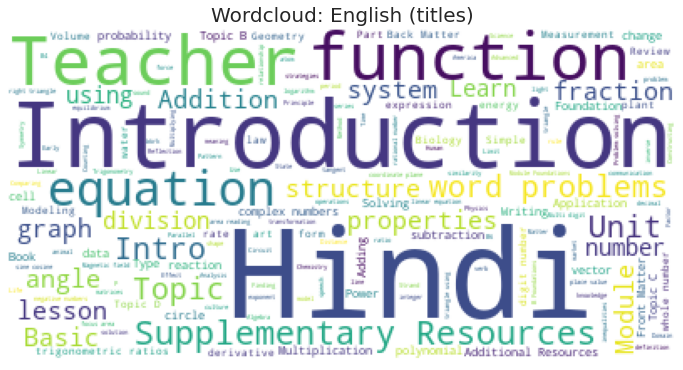

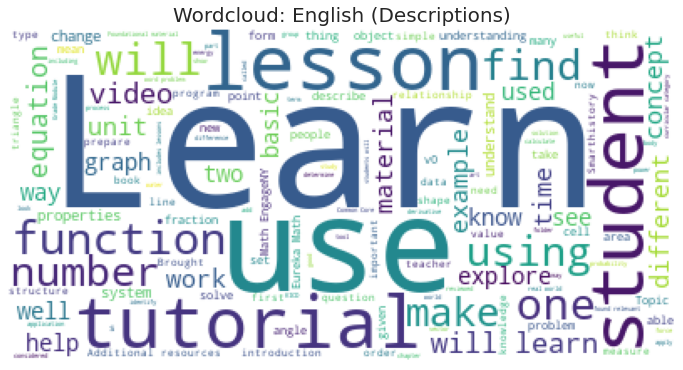

In [20]:
title = 'Wordcloud: English (titles)'    
text = topics_en["title"]
word_cloud(text, title)

title = 'Wordcloud: English (Descriptions)'    
text = topics_en["description"]
word_cloud(text, title)

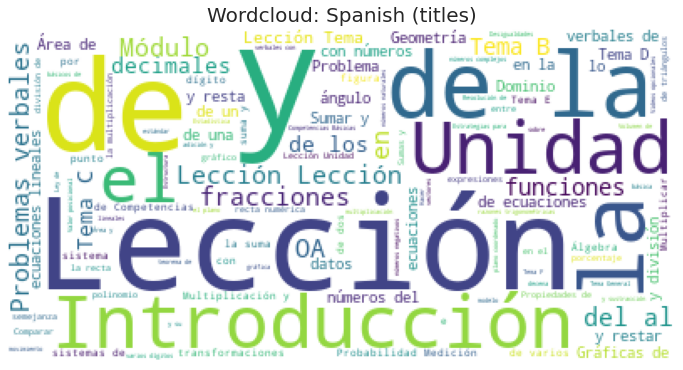

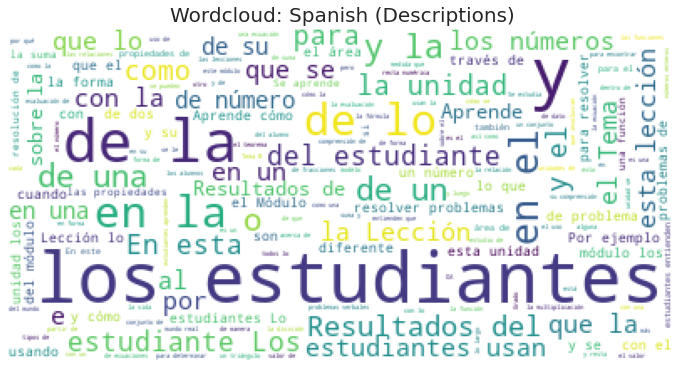

In [21]:
topics_es = (topics[topics['language'] == 'es']).dropna()
title = 'Wordcloud: Spanish (titles)'    
text = topics_es["title"]
word_cloud(text, title)

title = 'Wordcloud: Spanish (Descriptions)'    
text = topics_es["description"]
word_cloud(text, title)

In [22]:
topics.columns

Index(['id', 'title', 'description', 'channel', 'category', 'level',
       'language', 'parent', 'has_content'],
      dtype='object')

Number of channels : 171


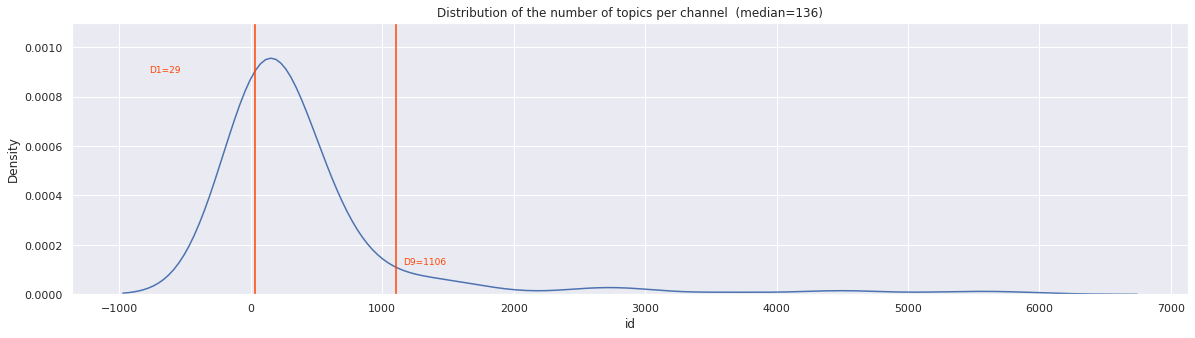

In [23]:
print("Number of channels :", len(topics['channel'].unique()))

agg = topics.groupby('channel').agg(lambda x: len(list(x)))['id']

sns.kdeplot(agg)
plt.title(f'Distribution of the number of topics per channel  (median={np.median(agg):.0f})')

d1 = int(np.percentile(agg, 10))
plt.axvline(d1, c="orangered")
plt.text(d1 - 800, 0.0009, s=f'D1={d1}', c="orangered", size=9)

d9 = int(np.percentile(agg, 90))
plt.axvline(d9, c="orangered")
plt.text(d9 + 50, 0.00012, s=f'D9={d9}', c="orangered", size=9)

plt.ylim(0, 0.0011)
plt.show()

<AxesSubplot:xlabel='level', ylabel='count'>

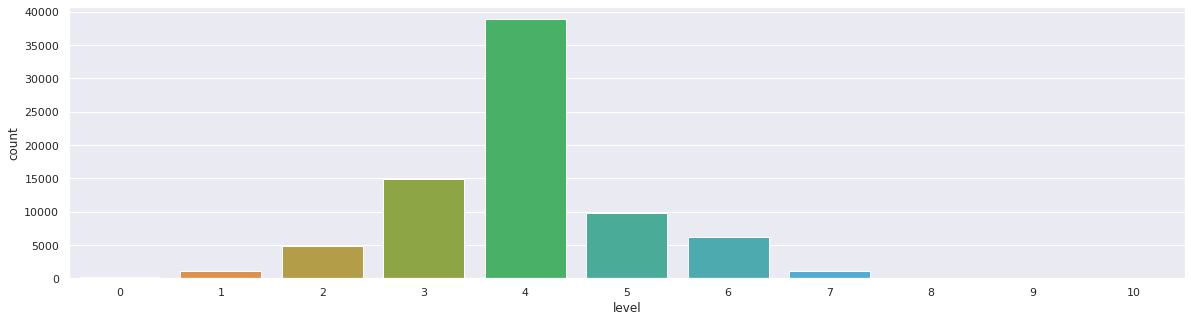

In [24]:
# Our level numbers
sns.set(rc={'figure.figsize':(20,5)})
sns.countplot(x='level', data=topics)

We have 11 levels out of which
Level 4 is having highest topics followed by 3 and 5

# Correlations

In [25]:
correlations.head()

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4


let's see how many content ID's we have for each topic

In [26]:
n_corrs=correlations['content_ids'].apply(lambda x:len(x.split(' ')))
print('Total number of correlations :', n_corrs.sum())
print('Average number of correlations per topic :', np.round(n_corrs.mean(), 1))
print('Minimum number of correlations per topic :', n_corrs.min())
print('Maximum number of correlations per topic :', n_corrs.max())

Total number of correlations : 279919
Average number of correlations per topic : 4.6
Minimum number of correlations per topic : 1
Maximum number of correlations per topic : 293


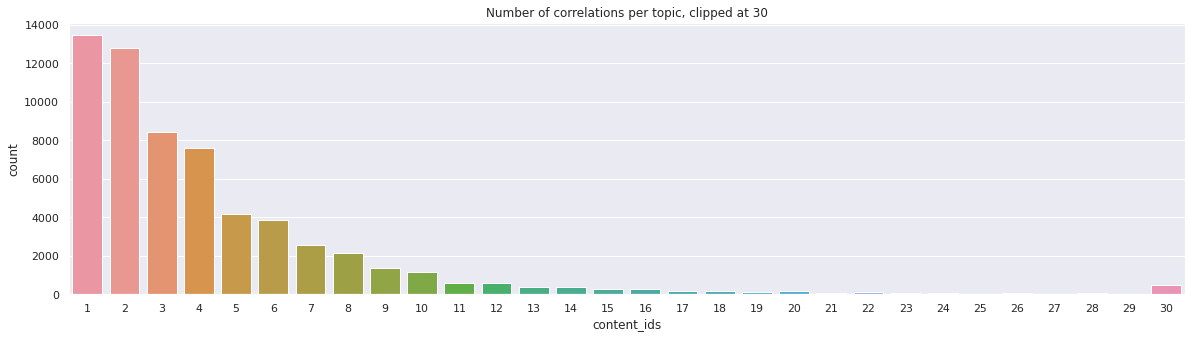

In [27]:
sns.countplot(x=np.clip(n_corrs,0,30))
plt.title('Number of correlations per topic, clipped at 30')
plt.show()

## Submission file

In [28]:
submission.head()

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_4054df11a74e,c_3695c5dc1df6 c_f2d184a98231


> So above in the sample above we see for each topic a set of content ids being recommended and we need to craft something similar to this as challenge

# Train/val Split
Validating is not easy here, since topics & contents are both new in the test set. What I want to do here is :

* Ignore category == source, it is not in the test set, so we can use these for training only.
* Split on channel. I assume channels will be new in the test set as well.
* Find a split that minimizes overlap between associated contents

In [29]:
topics_val=topics[topics['category']!='source'][['channel','id']]
topics_val=topics_val.merge(correlations,left_on='id',right_on='topic_id')

In [30]:
channel_val=topics.groupby('channel').agg(list).reset_index()

In [31]:
channel_val.head(1)

,channel,id,title,description,category,level,language,parent,has_content
0,000cf7,"[t_00004da3a1b2, t_0006d41a73a8, t_0028be2658c...","[Откриването на резисторите, Графики на експон...","[Изследване на материали, които предизвикват н...","[source, source, source, source, source, sourc...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, ...","[bg, bg, bg, bg, bg, bg, bg, bg, bg, bg, bg, b...","[t_16e29365b50d, t_e2452e21d252, t_356bd3157b1...","[True, True, True, True, True, True, True, Tru..."


In [32]:
channel_val = topics_val.groupby("channel").agg(list).reset_index()
channel_val['content_ids'] = channel_val['content_ids'].apply(lambda x: list(np.unique(np.concatenate([x_.split(' ') for x_ in x]))))

In [33]:
def iou(a, b):
    return len(set(a).intersection(set(b))) / len(set(a + b))

In [34]:
ious = np.zeros((len(channel_val), len(channel_val)))

for i in range(len(channel_val)):
    for j in range(i):
        iou_ij = iou(channel_val['content_ids'][i], channel_val['content_ids'][j])
        ious[i, j] = iou_ij
        ious[j, i] = iou_ij

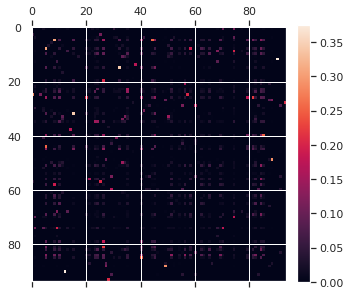

In [35]:
im = plt.matshow(ious)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

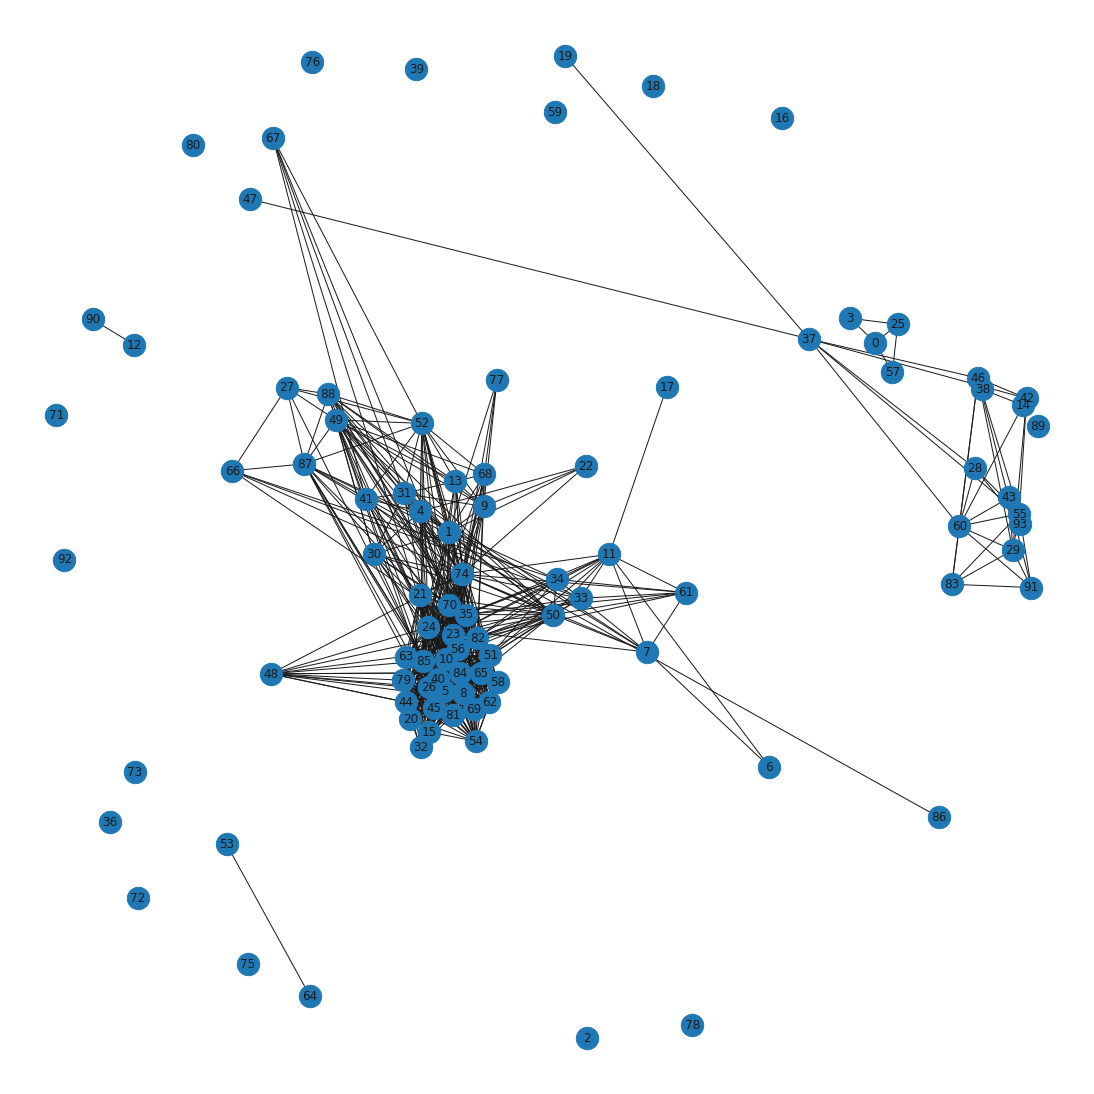

In [36]:
G = nx.Graph(ious)  # you can also threshold ious

plt.figure(figsize=(15, 15))
nx.draw(G, node_size=500, with_labels=True)